In [14]:
%matplotlib inline
from netCDF4 import Dataset as nc, num2date
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.basemap import Basemap, cm as cmap
import matplotlib.gridspec as gridspec
from matplotlib import cm
import os
import sys
import pytz
from datetime import datetime, timedelta
from cross_sect import getCrossSection, haversine
import matplotlib
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

### Define the input netCDF data
First define the experiment setup to construct the input files. The Experiment setup contains the following info:
 * domwain_name = Where took the experiment place
 * exp_id       = What is the parametrization setup
 * init_time    = The time of initialisation
 
Then define all the input-fields, where they are stored and the variable names
Also define the Experiment-setup to 

In [2]:
datadir = os.path.join(os.getenv('HOME'), 'Data', 'Extremes', 'UM')
domain_name = 'darwin'
exp_id = 'RA1T'
modeldir = []
init = ('20061110T0000Z', '20061110T1200Z', '20061117T0000Z', '20061117T0000Z')
for init_time in init:
        modeldir.append(os.path.join(datadir, domain_name, exp_id, init_time))
timezone = pytz.timezone('Australia/Darwin')
utc = pytz.UTC

Now get all files model input and observations

In [3]:
cpolF = os.path.join(datadir,'CPOL_2p5km_2006111000-2006111823.nc')
umf = {}
for t in ('surf', 'w', 'precip'):
    umf[t] = []
    for i, path in enumerate(modeldir):
        tmp = os.path.join(path,'UM_0p44km_%s_%s.nc'%(t,init[i]))
        if os.path.isfile(tmp):
            umf[t].append(tmp)

### Read the data with xarray define the smalest common area and get the common time-steps

In [4]:
cpol = xr.open_dataset(cpolF)
um_p00 = xr.open_dataset(umf['precip'][0])
um_p12 = xr.open_dataset(umf['precip'][1])
um_w00 = xr.open_dataset(umf['w'][-2])
um_w12 = xr.open_dataset(umf['w'][-1])
um_s00 = xr.open_dataset(umf['surf'][-2])
um_s12 = xr.open_dataset(umf['surf'][-1])

Round the times to the next 10 min

In [5]:
for f, tvar, fname in ((um_s00, 't', umf['surf'][0]), (um_s12, 't', umf['surf'][1]), (cpol, 'time', cpolF), 
                      (um_w00, 't', umf['w'][0]), (um_w12, 't', umf['w'][1]), (um_p00, 't', umf['precip'][0]),
                      (um_p12, 't', umf['precip'][1])):
    with nc(fname) as ncf:
        try:
            T=pd.DatetimeIndex(num2date(ncf.variables['time'][:],ncf.variables['time'].units)).round('10min')
        except KeyError:
            T=pd.DatetimeIndex(num2date(ncf.variables['t'][:],ncf.variables['t'].units)).round('10min')
        f[tvar] = T

In [ ]:
for f in (um_p00, um_p12, um_w00, um_w12, um_s00, um_s12, cpol):
    f.close()

In [6]:
lons, lats, times = [], [], []
for dataset, lonn, latn, timen in ((cpol, 'longitude', 'latitude', 'time'),
                                  (um_s00, 'longitude', 'latitude', 't'),
                                  (um_s12, 'longitude', 'latitude', 't')):
    lon, lat, time = dataset[lonn].values, dataset[latn].values, dataset[timen].values
    lons.append((lon.min(), lon.max()))
    lats.append((lat.min(), lat.max()))
    times.append((time.min(), time.max()))
lons, lats, times = np.array(lons), np.array(lats), np.array(times, dtype='datetime64[m]')
domain_ko = dict(minlon=lons[:,0].max(), maxlon=lons[:,1].min(), maxlat=lats[:,1].min(), minlat=lats[:,0].max())
times = pd.date_range(times[:,0].max(), times[:,1].min(), freq='10 min')

In [7]:
print(times)

DatetimeIndex(['2006-11-17 00:00:00', '2006-11-17 00:10:00',
               '2006-11-17 00:20:00', '2006-11-17 00:30:00',
               '2006-11-17 00:40:00', '2006-11-17 00:50:00',
               '2006-11-17 01:00:00', '2006-11-17 01:10:00',
               '2006-11-17 01:20:00', '2006-11-17 01:30:00',
               ...
               '2006-11-18 04:20:00', '2006-11-18 04:30:00',
               '2006-11-18 04:40:00', '2006-11-18 04:50:00',
               '2006-11-18 05:00:00', '2006-11-18 05:10:00',
               '2006-11-18 05:20:00', '2006-11-18 05:30:00',
               '2006-11-18 05:40:00', '2006-11-18 05:50:00'],
              dtype='datetime64[ns]', length=180, freq='10T')


### Define the corss section

In [8]:
start_point = dict(lon=129.995, lat=-11.2285)
end_point = dict(lon=131.339, lat=-11.818)
with nc(os.path.join(datadir,'UM_0p44km_orog.nc')) as g:
    H = g['ht'][0,0,:]
idx = getCrossSection((start_point['lon'], start_point['lat']),
                      (end_point['lon'], end_point['lat']), um_p00['longitude'], um_p00['latitude'], 0.905)
sec = H[idx]
dist = haversine(start_point['lon'], end_point['lon'], start_point['lat'], end_point['lat'])
mpl.rcParams['contour.negative_linestyle'] = 'dashed'

### Plot cross section

In [9]:
plotdir=os.path.join(datadir,'Plot','Week_of_Hector')
first = True
T = times[:].tz_localize(utc).tz_convert(timezone)


Get the surface pressure along that line

In [10]:

plev = um_w00['p'][:6][::]
dz=0.48

In [11]:
w=2.5
wlev=np.linspace(-w,w,10)

 Creating SeaBreeze-2006-11-17_0930.png .... 

/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/lib/python3/dist-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


 Creating SeaBreeze-2006-11-18_1520.png .... ok

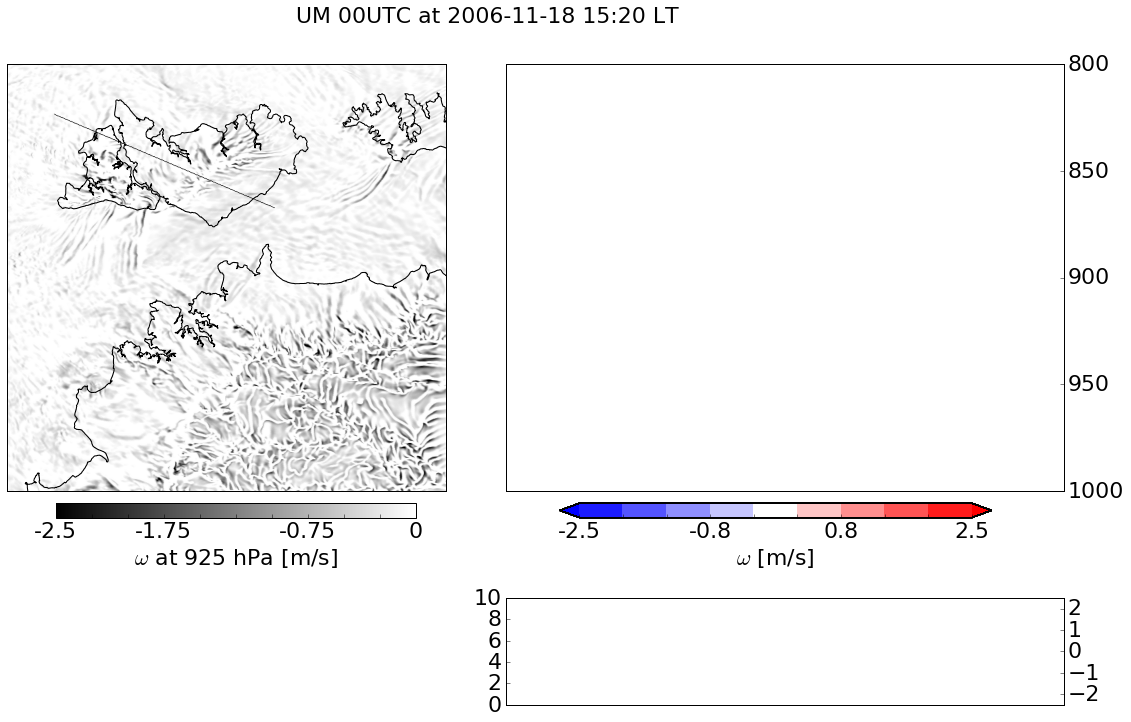

In [20]:
first = True
plotdir=os.path.join(datadir,'Plot','Week_of_Hector')
cma = cm.binary_r
cma.set_bad('red')
X, Y = np.meshgrid(np.linspace(0,dist,len(sec)),plev)
for nn in range(len(times[:])):
    nn1 = nn
    nn2 = nn
    t1 = times[nn1]
    t2 = times[nn2]
    now1 = t1.tz_localize(utc).tz_convert(timezone)
    now2 = t2.tz_localize(utc).tz_convert(timezone)
    fname = os.path.join(plotdir,'SeaBreeze-%s.png'%(now1.strftime('%Y-%m-%d_%H%M')))
    sys.stdout.flush()
    sys.stdout.write('\r Creating %s .... '%os.path.basename(fname))
    sys.stdout.flush()
    
    w2 = um_w00['dz_dt'].loc[t1][:6].values[:,idx[0],idx[1]]
    w1 = um_w00['dz_dt'].loc[t2][2].values
    w1[idx]=np.nan
    p1 = 100*um_p00['field1681'].loc[t1].values[idx]
    p2 = 100*um_p00['field1681'].loc[t2].values[idx]
    temp1 = um_s00['temp'].loc[t1][0].values[idx] - um_s00['temp'].loc[t1].values[0,idx[0],idx[1]].mean()
   
    
    
    tit1 = 'UM 00UTC at %s'%(now1.strftime('%Y-%m-%d %H:%M LT'))
    tit2 = 'UM 00UTC at %s'%(now2.strftime('%Y-%m-%d %H:%M LT'))
    if first:
        fig = plt.figure(figsize=(20,10), dpi=72)
    
        gs = gridspec.GridSpec(6, 2, height_ratios=[4, 1])
        ax1 = plt.subplot2grid((6, 2), (0, 0),rowspan=4)
        ax2 = plt.subplot2grid((6, 2), (0, 1),rowspan=4)
        ax3 = plt.subplot2grid((6, 2), (-1, 1), colspan=1)
        m = Basemap(llcrnrlon=domain_ko['minlon'], urcrnrlon=domain_ko['maxlon'], llcrnrlat=domain_ko['minlat'],
                     urcrnrlat=domain_ko['maxlat'], resolution='f', area_thresh=100., ax = ax1)
        im = m.pcolormesh(um_w00['longitude'], um_w00['latitude'], w1, vmin=-2.5, vmax=0., cmap=cma,
                              shading='gouraud')
        first = False
        
        #cb1 = m.colorbar(im,location='bottom',pad="5%")
        m.drawcoastlines()
        cax1 = fig.add_axes([0.2, 0.27, 0.25, 0.02])
        cbar = fig.colorbar(im, cax=cax1, orientation='horizontal')
        cbar.set_label('$\\omega$ at 925 hPa [m/s]')
        cbar.ax.set_xticklabels([-2.50,'','',-1.75,'','','',-0.75,'','',0])
        fig.subplots_adjust(bottom=0.01, hspace=0.0, wspace=0.0) 
        ax22 = ax2.twinx()
        ax22.invert_yaxis()
        ax32 = ax3.twinx()
    else:
        im.set_array(w1.ravel())
        for ax in (ax2, ax3, ax32):
            ax.cla()
    #ax1.invert_yaxis()
    
    #S1 = ax1.contourf(X, Y, w1[::-1,:], np.linspace(-w,w,10), extend='both', cmap=cmap.GMT_polar)
    S2 = ax22.contourf(X, Y, w2[:,:],wlev, extend='both', cmap=cmap.GMT_polar)
    cax2 = fig.add_axes([0.55, 0.27, 0.3, 0.02])
    cbar2 = fig.colorbar(S2, cax=cax2, orientation='horizontal')
    cbar2.ax.set_xticklabels([-w,'','',wlev[3].round(1),'','',wlev[-4].round(1),'','',w])
    cbar2.set_label('$\\omega$ [m/s]')
    #cb2 = plt.colorbar(S2, ax=ax2, orientation='horizontal')
    #cb2.set_label(label= '$\\omega $[m/s]') #weight='bold')
    
    #ax1.fill_between(np.linspace(0,dist,len(sec)),1000,(1000-(dz*sec)),color='k')
    ax22.fill_between(np.linspace(0,dist,len(sec)),1000,(1000-(dz*sec[::-1])),color='k')
    ax3.plot(np.linspace(0,dist,len(sec)),p1)
    for ax in (ax1, ax2, ax3):
        ax.xaxis.set_visible(False)
        ax.set_xticklabels([])
    ax2.yaxis.set_visible(False)
    ax2.set_yticklabels([])
    ax22.set_ylabel('pressure [hPa]')
    ax32.plot(np.linspace(0,dist,len(sec)),temp1, color='r')
    ax32.set_ylim(-2.5,2.5)
    
    #ax3.legend(loc=1)
    #ax1.set_title(tit1)
    plt.suptitle(tit2,size=22)
    #cbar_ax = fig.add_axes([0.14, 0.27, 0.74, 0.02])
    #cbar=fig.colorbar(S1, cax=cbar_ax, orientation='horizontal')
    #cbar.set_label('$\\omega$ [m/s]')
    fig.subplots_adjust(bottom=0.01, hspace=0.0, wspace=0.0)
    ax3.set_ylabel('Rain [mm/h]',color='b')
    ax32.set_ylabel('Temp. [$^\\circ$C]',color='r')
    
    ax3.set_ylim(0,10)
    fig.savefig(fname, bbox_inches='tight', format='png', dpi=72)
    #break
    for ax in (ax2, ax22, ax32, ax3):
        ax.cla()
    sys.stdout.flush()
    sys.stdout.write('\r Creating %s .... ok'%os.path.basename(fname))
    sys.stdout.flush()